# Neural Networks and Learning Machines
## ANN 1 - Training, validation, and testing
This exercise is split into three different parts. First, you will test some simple machine learning models that aren't neural networks. Secondly, you will implement and train a 2 layer neural network using a high level library, [pytorch](https://pytorch.org/). Finally, you will create the neural network, the forward pass and the backward pass from scratch using numpy. The data which will be used is a subset of the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset which contains handwritten numbers from 0-9. Examples can be seen in the image below.

![MNIST digits](https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png)

## Literature
Before starting with the implementation you should familiarize yourself with relevant sections from the [course book](https://www.deeplearningbook.org/). This will help you understand the theory behind neural networks and what mathematical formulas are important for the task. The lectures has touched on most of these concepts too. Below will be a list of recommended sections from the book. If you feel you are already familiarize with the contents of the section, feel free to skip it.

* Chapter 5 - Machine learning basics
    - Section 5.1 - Explains the basics of what we mean by learning and what supervised learning is (including linear regression).
    - Section 5.2 - Talks about generalization, the generalization gap and under/overfitting.
    - Section 5.3 - Validation and validation set.
* Chapter 6 - Deep feedforward networks
    - Section 6.0 - Discusses what do we mean by feedfoward networks and terminology such as input layer, output layer and hidden layer.
    - Section 6.2 - Discusses what gradient based learning is and what cost functions are.
    - Section 6.5 - Explains back propagation. Important here are the formulas 6.49 - 6.52.
* Chapter 8 - Optimization for Training Deep Models
    - Section 8.1.3 - Presents differences between batch (deterministic) and mini-batch (stochastic) algorithms.
    
## Examination

### Part 1

* Try 4 machine learning models that are not Neural Networks using scikit-learn: decision tree, linear regression, logistic regression, and Support-Vector Machine (SVM)
* Write a short description of the main difference between linear and logistic regression in the provided cell.

### Part 2
* Implementation of a 2 layer NN (very similar to ex0)
* Training of this 2 layer NN (once again, very similar to ex0)
* Validation of the network during training (requires splitting the training set)
    - Save the model which performs the best on the validation data
* Graph the training loss vs validation loss
* At least 85% accuracy on the test data (remember to load the best performing model before performing the accuracy test)

### Part 3
* Implementation of a 2 layer NN using numpy
* Training and validation of the 2 layer NN
    - Once again, save the best performing model (can be done in memory)
* Graph the training vs validation loss
* At least 50% accuracy on the validation data (can be hard to get high accuracy)

# MNIST dataset preparation
We will start by importing the packages we'll be using as well as downloading and preparing the data such that it is usable for our purposes.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler


import matplotlib.pyplot as plt
import numpy as np
import copy
import sys
!pip install torchinfo
from torchinfo import summary

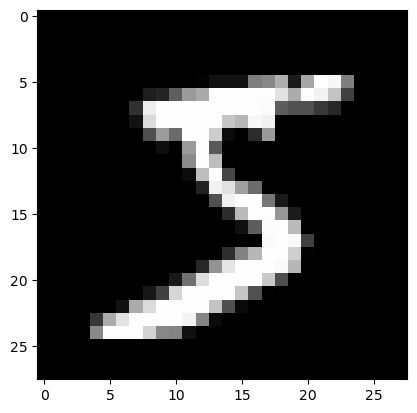

In [2]:
# Define the mini-batch size
batch_size = 1000

# Download the dataset and create the dataloaders
mnist_train = datasets.MNIST("./", train=True, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=False)
## IN PART 2 YOU MAY WANT TO ADD A WAY TO SPLIT THE DATASET HERE##

mnist_test = datasets.MNIST("./", train=False, download=True, transform=transforms.ToTensor())
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

to_onehot = nn.Embedding(10, 10)
to_onehot.weight.data = torch.eye(10)

def plot_digit(data):
    '''Previews an image from the dataset'''
    data = data.view(28, 28)
    plt.imshow(data, cmap="gray")
    plt.show()
    
images, labels = next(iter(train_loader))
plot_digit(images[0])

In [3]:
# Function Definition

def predict_on_images(iterator, images_to_show):
    '''Displays several images before printing predicted values'''
    for index in range(images_to_show):
        # Get the next batch of images
        images, labels = next(iterator)

        plot_digit(images[0])

        # Transform the images into a single list of pixels since our network takes that as its input
        input_tensor = images[0].view(1,784)
        # Run the input through our network to get a prediction
        prediction = network(input_tensor)
        # Extract which prediction had the highest probability
        guess = torch.argmax(prediction[0], dim=-1)
        # Show the predicted digit and the actual digit
        print(f'Prediction: {guess.item()} - Actual: {labels[0].item()}')
    

def get_epoch_loss(some_loader):
    '''Calculates loss for every epoch for a given data loader.
    Call this function from within training loop.'''
    loss_list = []
    for batch_nr, (images, labels) in enumerate(some_loader):
        labels = to_onehot(labels)
        images = images.view(-1,784)
        prediction = network(images)
        loss_list.append(loss_function(prediction, labels))
    return sum(loss_list)/len(loss_list)


def get_acc(some_loader):
    '''Computes the neural network's accuracy on an arbitrary data loader.'''
    matches = 0
    datapoints = 0
    for batch_nr, (images, labels) in enumerate(some_loader):
        labels = to_onehot(labels)
        images = images.view(-1,784)
        prediction = network(images)

        preds = prediction.detach().numpy()
        labls = labels.detach().numpy()

        matches += sum([np.argmax(preds[i]) == np.argmax(labls[i]) for i in range(len(preds))])
        datapoints += len(labels)
    return matches/datapoints


# Part 1

## Test some non-neural network machine learning models

Neural Networks are just a small part of the large field of machine learning. Many machine learning models exist that does not fall under the umbrella of neural networks and it's good to be familiar with some of them.
In this part of the exercise you will test decision tree, linear regression, logistic regression, and Support-Vector Machine (SVM) models using their implementations from the scikit-learn package.

To start with let's have quick walk-through of the methods we'll be using:

**Decision trees** work by inserting a data point into the root of the tree and then by comparing different features of the data point it is sent to the next step in the tree until it reaches a leaf node which contains the final prediction for the data point. There are many different ways to create a tree to fit some training set but training procedures often follow a divide-and-conquer strategy:
* Find an attribute that splits the different classes or labels of the training data as neatly as possible and create a node that splits using that attribute.
* Repeat the procedure to create the subnodes using the training data that subnode would encounter.
* This is repeated for each until either a performance requirement or a certain depth is reached at which point each leaf node is assigned as a predictor for the highest liklihood label to reach that node.

An example of a short decision tree can be found in the image below.
![Decision Tree](https://miro.medium.com/max/720/1*YTg8AE3nAsbfn-elHuJNIA.jpeg)

**Linear regression, logistic regression, and SVM** are all versions of linear models. Linear models work by, for training data in some hyper-space (a space with N dimensions) learning a hyperplane (a plane with N-1 dimensions) that fits the data best. In the case of binary classification the goal is to have as many samples of each class on separate sides of the plane. The calculation of a linear model can be described by the vector equation below, where *x* is the data point and **w** and b are learned parameters, and f() is an activation function.

\begin{equation*}
y = f(\mathbf{w}\mathit{x} + b)
\end{equation*}

As you can see this is identical to the equation of an artificial neuron, and when extended to handle multiple outputs (by using  matrices for **w** and b instead of vectors) become equivalent to a single-layer ANN.
However, even though prediction, in the simplest case, is equivalent to a single-layer neural network there are many different linear models that vary in different ways. Common things to change is activation function, learning method, optimization criteria, or the addition of kernel functions to bring complex datasets into higher dimensional spaces where it's easier to linearly separate. So, while it may seem pointless to use a linear model when they seem equivalent to a single-layer neural network, some models come with advantages that neural network have difficulty replicating. A common advantage is that while neural networks often needs to be trained using backpropagation, linear models are well-studied with many different optimization short-cuts and techniques0.

As you will see when running the models below, these models all get impressive results on the dataset, despite their apparent simplicity. To test these models we're using their implementation from the Python library [Scikit-Learn](https://scikit-learn.org/stable/index.html) which contains implementations of a host of different machine learning models and methods. While knowing a Scikit-Learn is not mandatory for this Exercise, it's well worth having a look at for anyone interested in non-neural network machine learning (though it does contain some neural networks as well).

**Exercise:** Look through the code below and run it to get the results of the different machine learning models (You might get some warnings, but don't worry about those). Then read up on linear and logistic regression and write a short description of their difference in the cell below

In [4]:
# Since Scikit-Learn uses Numpy we need to transform all our data to numpy arrays, 
# which can be done by Pytorch's .numpy() function
X_train = mnist_train.data.view(-1, 784).numpy()
y_train = mnist_train.targets.numpy()
y_10_train = to_onehot(mnist_train.targets).detach().numpy()

X_test = mnist_test.data.view(-1, 784).numpy()
y_test = mnist_test.targets.numpy()

# Many machine learning models in Sciki-Learn work better if the data has been normalized to mean 0 and Std. Dev. 1
# which can be done with Scikit-Learn's StandardScaler 
scaler = StandardScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


# We make a function for handling the training and testing of a given Scikit-Learn classifier
def train_and_test(classifier, train_data, train_labels, test_data, test_labels, onehot_output=False):
    # Trains the classifier witht he given data and labels
    classifier.fit(train_data, train_labels)
    # Uses the trained classifier to predict the classes of the test set
    predictions = classifier.predict(test_data)
    # Some models output with predictions for each class rather than one index for the predicted class
    if onehot_output:
        predictions = np.argmax(predictions, axis=1)
    # By comparing the actual labels to the predictions we can calculate the accuracy of the classifier
    return accuracy_score(test_labels, predictions)


# We create the classifiers to test
classifiers = {
    "Decision Tree": DecisionTreeClassifier(),
    "Linear Regression": LinearRegression(),
    # We use the SGDClassifier (which trains a linear model using SGD) to implement Logistic Regression and SVM
    "Logistic Regression": SGDClassifier(loss='log_loss', max_iter=200),
    "SVM": SGDClassifier(loss='hinge', max_iter=200)
}


# We train and test each classifier
for classifier in classifiers:
    onehot_output = classifier == "Linear Regression"
    y = y_10_train if onehot_output else y_train
    result = train_and_test(classifiers[classifier], X_train, y, X_test, y_test, onehot_output=onehot_output)
    print("Classifier {} got {}% accuracy on the test set".format(classifier, result*100))

Classifier Decision Tree got 87.63% accuracy on the test set
Classifier Linear Regression got 86.02% accuracy on the test set


C:\Users\Vaishob\.conda\envs\nnlm\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:704: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Classifier Logistic Regression got 87.57000000000001% accuracy on the test set
Classifier SVM got 89.05% accuracy on the test set


C:\Users\Vaishob\.conda\envs\nnlm\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:704: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


#### Exercise: Explain in three or four sentences the main difference between linear- and logistic regression.



Linear regression is used to model the relationship between a dependent variable and one or more independent variables, and it produces a continuous output. Logistic regression, on the other hand, is used to model the probability of a binary outcome based on one or more independent variables, and it produces a probability score that ranges between 0 and 1. 

In linear regression, the output is a linear function of the input variables, while in logistic regression, the output is a non-linear function of the input variables. Logistic regression is often used for classification problems, while linear regression is used for regression problems.

# Part 2

## Implement a classifier using pytorch

Given the code below, your knowledge from the literature, lectures, and exercise 0. Implement a 2 layer neural network using pytorch as well as the procedure for training, validation, and testing.

The training should include both training and validation. As such you need to split the training data into a training set (for which the error is backpropagated to update the parameters) and a validation set (which will not be used to directly update the model parameters, and instead be used to keep track of how good the model is at unseen data). The weights of the model which performs the best on the validation det should be stored and then be used for the final check on the test set. Validation sets are often created by taking a fraction of the training data (often, but not always, around 20%) at random. In Pytorch you might want to use [random_split](https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split)() for this. Using random split would require you to edit the way the Dataloaders are created. If you edit the data collection provided, make sure you retain the old DataLoaders as they are used in part 1.

You are free to choose any optimizer and loss function. Just note that some loss functions require the labels to be 1-hot encoded. As you will not use convolutional layers for this exercise (later in the course), the input needs to be changed to a 1d tensor (see [view](https://pytorch.org/docs/stable/tensors.html?highlight=view#torch.Tensor.view)()).

**Exercise:** Implement a 2-layer NN as well as the procedures for training, validation, and testing. You should use the network from the epoch with best validation score on the test set which should achive at least 85% accuracy.

***Remember*** to run all your code before grading so the TA doesn't have to wait around for long training runs. Plot the training and validation losses for each epoch.

*Hint:* Validation and Testing loops are very similar to training except they don't use backpropagation. Additionally testing should only be performed once, while validation should be performed continually to make sure training is proceeding as intended and to save the parameters of the best epoch.

*Hint:* Storing the best model is a bit more difficult than just assigning it to a variable as this only means you have to variables pointing to the same network, not one containing the best one and one containing the current. Instead you ned to make a copy of the network which can be achived with [deepcopy](https://docs.python.org/3/library/copy.html)(). Other ways to store models include saving them as a file which can be done with [torch.save](https://pytorch.org/tutorials/beginner/saving_loading_models.html)().

*Hint:* Everytime you train a network random initialization and random mini-batches means that you get networks with different performance. Sometimes just running the training again can be enough to get a better result. However, if you do this too many times you run the risk of training (overfitting) on the test set.

In [5]:
# Implement 

# Define the mini-batch size
batch_size = 1000

# Download the dataset and create the dataloaders for training
mnist_train = datasets.MNIST("./", train=True, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=False)

# Download the dataset and create the dataloaders for validation
mnist_validation = datasets.MNIST("./", train=False, download=True, transform=transforms.ToTensor())
validation_loader = DataLoader(mnist_validation, batch_size=batch_size, shuffle=False)

to_onehot = nn.Embedding(10, 10)
to_onehot.weight.data = torch.eye(10)

In [6]:
# Training

# Define the network
network = nn.Sequential(
    nn.Linear(784, 100),
    nn.ReLU(),
    nn.Linear(100, 10)
    )

# Some hyperparameters
epochs = 30
lr = 1
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.SGD(network.parameters(), lr=lr)

# Training loop
train_losses = []
valid_losses = []
for epoch in range(epochs):
    for batch_nr, (images, labels) in enumerate(train_loader):

        # Reshape data & labels to match network
        labels = to_onehot(labels)
        images = images.view(-1,784)

        # Make a prediction and compute its loss
        prediction = network(images)
        loss = loss_function(prediction, labels)

        # Upgrade weights
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Print the epoch, batch, and loss
        print('\rEpoch {}/{} [{}/{}] - Loss: {}'\
            .format(epoch+1, epochs, batch_nr+1, len(train_loader), loss),end='')

    # Get losses per epoch for validation and train sets
    train_losses.append(get_epoch_loss(train_loader))
    valid_losses.append(get_epoch_loss(validation_loader))

Epoch 30/30 [60/60] - Loss: 0.009727815166115764


> ACCURACY ON TRAINING SET: 0.9630833333333333
> ACCURACY ON VALIDATION SET: 0.9602
> Hyperparameters:
	Training epochs: 30
	Loss function: MSE
	Optimizer: SGD
	Learning rate: 1
> MODEL: Sequential(
  (0): Linear(in_features=784, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=10, bias=True)


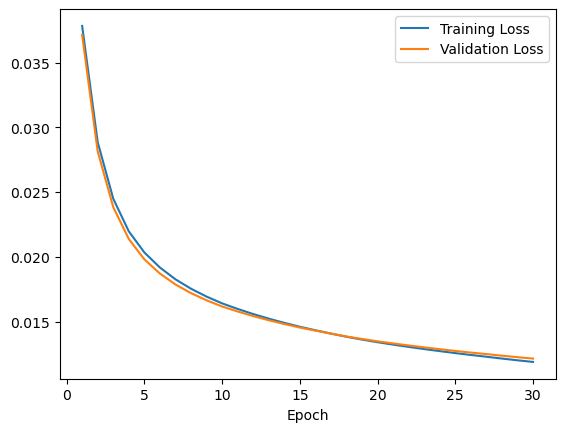

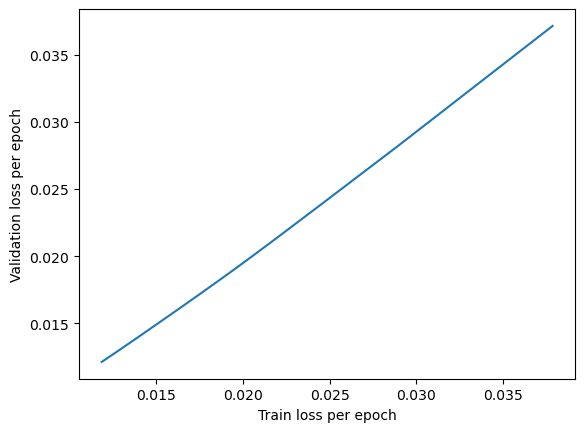

In [15]:
# Evaluating & overengineered printing of data 4321

# String with information about model and results
log = str(f'''
> ACCURACY ON TRAINING SET: {get_acc(train_loader)}
> ACCURACY ON VALIDATION SET: {get_acc(validation_loader)}
> Hyperparameters:
\tTraining epochs: {epochs}
\tLoss function: MSE
\tOptimizer: SGD
\tLearning rate: {lr}
> MODEL: {str(network)[:-2]}''')

# Display on terminal
print(log)


train_losses = torch.tensor(train_losses)
valid_losses = torch.tensor(valid_losses)
# Plot stored losses per epoch 
plt.plot(range(1,epochs+1), train_losses, label='Training Loss')
plt.plot(range(1,epochs+1), valid_losses, label='Validation Loss')
plt.legend(loc="upper right")
plt.xlabel('Epoch')
plt.show()

# Plot validation loss against training one
plt.plot(train_losses, valid_losses)
plt.xlabel('Train loss per epoch')
plt.ylabel('Validation loss per epoch')
plt.show()


# Part 3

## Implement a classifier using numpy
Implement a similar 2 layer neural network, without using a high-level machine learning library like pytorch. It should function the same as the network in Part 2. The code block below contains code to change the training data from the DataLoader format to the "raw" numpy format. It also contains some comments to guide you in the right direction. **Please note that this solution should not "scale" hence it is 100% OK to just have two weight matrices variables.**

### The forward pass
This is easy. Recall that each differnt layer is calculated by the formula: 
$$ y = g(\mathbf{W}*\mathbf{x} + b) $$
where $W$ is the weight matrix, $x$ the input, $b$ the bias and $g$ the non-linearity. For this exercise you are allowed to put $b = 0$ for simplicity when calculating the backwards pass.

### Backward pass
This can be tricky. In canvas there is lecture material which explains back propogation and all the maths behind it. It should be under *Modules > Artificial Neural Networks (ANN) - Part 1 > Lecture: Backpropagation derivation.mp4*. This, the supplementary material for the lecture, together with the course book should be enough material for you to be able to implement the training algorithm.

### Weight update
Once you have calculated the gradient of both weight matrixes, this is updated by:
$$ W_i = W_i - \gamma \dfrac{dL}{dW_i} $$
where $\gamma$ is the step size, or learning rate.

**Exercise:** Implement a 2-layer NN and training, valdiation, and testing like in Part 2, but this time implementing everything using Numpy, which requires you to define your own forward pass, backward pass, and parameter updates. Then plot the training and validation scores and print the test accuracy which should be at least 40%.

***Remember*** to run all your code before grading so the TA doesn't have to wait around for long training runs.

In [16]:
# Importing data
# Define the mini-batch size
batch_size = 1000

# Download the dataset and create the dataloaders for training
mnist_train = datasets.MNIST("./", train=True, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=False)

# Download the dataset and create the dataloaders for validation
mnist_validation = datasets.MNIST("./", train=False, download=True, transform=transforms.ToTensor())
validation_loader = DataLoader(mnist_validation, batch_size=batch_size, shuffle=False)

# Defining transformations to one-hot encode labels later
to_onehot = nn.Embedding(10, 10)
to_onehot.weight.data = torch.eye(10)

In [17]:
# Function Definition
def relu_grad2(s):
    '''Derivative of the relu function for tensors'''
    return 1 * (s > 0)


def get_epoch_loss(some_loader):
    '''Get the loss per epoch for an arbitrary data loader. This is done for 
    each picture individually, then all losses are averaged to get an epoch's 
    loss.'''
    all_losses = []
    for batch_nr, (inputs, labels) in enumerate(some_loader):
        for i in range(batch_size):
            # Load one pic
            x = inputs[i].reshape((1, D_in))
            y = np.eye(10)[labels[i]]

            # Forward pass for one pic
            h = np.matmul(x, w1)
            h_relu = h * (h > 0)
            y_pred = np.matmul(h_relu, w2)

            # Loss func of this picture
            loss = sum(np.subtract(y, y_pred[0])**2)
            
            # Put each sample's lost on a list to average later (bc batchsize=1)
            all_losses.append(loss)

    return np.mean(all_losses)

def get_acc(some_loader):
    '''Measures the accuracy of a model for any w1 w2 weights stored in memory.
    This is a batched-input approach.'''
    matches = 0
    datapoints = 0
    for batch_nr, (inputs, labels) in enumerate(some_loader):

        # Load a bunch of pics and get rid of the nosy torch variable type
        x = np.array(inputs.view(-1,784).detach())
        y = np.array(to_onehot(labels).detach())

        # Forward pass
        h = np.matmul(x, w1)
        h_relu = h * (h > 0)
        y_pred = np.matmul(h_relu, w2)

        # Count number of matches and number of evaluated cases
        matches += sum([np.argmax(y_pred[i]) == np.argmax(y[i]) for i in range(len(y))])
        datapoints += len(y)
        
    return matches/datapoints

def get_acc_ext(some_loader, f1='w1.csv', f2='w2.csv'):
    ''' Measures the accuracy of a model with weights w1 w2 loaded from file.
    THIS IS YET ONLY FOR WORKING ON A LOCAL PYHTON INSTALL '''
    # Load weight matrices
    w1_file  = np.loadtxt(f1,delimiter=',')
    w2_file  = np.loadtxt(f2,delimiter=',')

    matches = 0
    datapoints = 0
    for batch_nr, (inputs, labels) in enumerate(some_loader):

        # Load a bunch of pics
        x = np.array(inputs.view(-1,784).detach())
        y = np.array(to_onehot(labels).detach())

        # Forward pass
        h = np.matmul(x, w1_file)
        h_relu = h * (h > 0)
        y_pred = np.matmul(h_relu, w2_file)
        
        # Count number of matches and number of evaluated cases
        matches += sum([np.argmax(y_pred[i]) == np.argmax(y[i]) for i in range(len(y))])
        datapoints += len(y)

    return matches/datapoints

In [18]:
# Training

# Provided hyperparameters
D_in = 784   # Input size, images are 28x28 = 784 element vectors
D_out = 10   # Output size, 10 digit classes
H1 = 100     # Hidden layer size
gamma = 1e-5 # Learning rate

# Custom hyperparameters
epochs = 10


# Randomize initial weights
# Do not rerandomize for deeper training!
rerandomize = True
if rerandomize:
    w1 = np.random.randn(D_in, H1)
    w2 = np.random.randn(H1, D_out)
else:
    try:
        w1 = w1
        w2 = w2
    except:
        print('You chose not to rerandomize, however no old weights were found :S')
        print('Continuing with random weight matrices...')
        w1 = np.random.randn(D_in, H1)
        w2 = np.random.randn(H1, D_out)    
        
# Storage for per-epoch accuracies
training_accuracies = []
validation_accuracies = []

# Storage for per-epoch average losses
training_losses = []
validation_losses = []

for epoch in range(epochs):

    for batch_nr, (inputs, labels) in enumerate(train_loader):
        #inputs = inputs.numpy()
        #labels = labels.numpy()

        for i in range(batch_size):
            # Load one pic
            x = inputs[i].reshape((1, D_in))
            y = np.eye(10)[labels[i]]

            # Layer 1 + relu activation
            h = np.matmul(x, w1)
            h_relu = h * (h > 0)

            # Layer 2
            y_pred = np.matmul(h_relu, w2)

            # Compute loss function (squared error), deliberately ignoring the 
            # linear transformation factor 1/Nsamples that defines the MEAN 
            # squared error.
            loss = sum(np.subtract(y, y_pred[0])**2)
            
            # Loss derivative w.r. to y_pred
            dL_dypred = -2 * np.subtract(y, y_pred)

            # Loss derivative w.r. to w2 (f2L is the recycled term on backprop)
            f2L = np.multiply(np.ones(dL_dypred.shape),
                              dL_dypred)  
            dL_dw2 = np.matmul(h_relu.T, f2L)   

            # Loss derivative w.r. to w1
            dL_dw1 = np.matmul(x.T,                                            
                               np.multiply(relu_grad2(np.matmul(x, w1)), 
                                           np.matmul(f2L, w2.T)))
            
            # Update weights
            w2 -= np.dot(gamma, dL_dw2)
            w1 -= np.dot(gamma, dL_dw1)

        # Loss display every 1000 samples (batch size) so as not to go bananas
        print('\rEpoch {}/{} - Loss: {}'.format(epoch+1, epochs, loss),end='')
    
    # Get these every epoch
    training_accuracies.append(get_acc(train_loader))
    validation_accuracies.append(get_acc(validation_loader))

    training_losses.append(get_epoch_loss(train_loader))
    validation_losses.append(get_epoch_loss(validation_loader))

print('')
print(f'FINAL TRAINING ACCURACY {get_acc(train_loader)}')
print(f'FINAL VALIDATION ACCURACY {get_acc(validation_loader)}')

Epoch 10/10 - Loss: 0.57183470393244216
FINAL TRAINING ACCURACY 0.5123
FINAL VALIDATION ACCURACY 0.5124


"\nTHIS IS ONLY FOR WORKING ON A LOCAL PYHTON INSTALL\n# save trained weights for later\nnp.savetxt('w1.csv', w1, delimiter=',')\nnp.savetxt('w2.csv', w2, delimiter=',')\n"

# Optional task
You have now implemented a 2 layer neural network from scratch. Use this new gained knowledge to create an implementation where we can create and train any sized network. This means that we should be able to specify the structure of the network and then train it using back propagation.